## Data imputation
In this notebook the inputation algorithms implemented are shown. This step is carried out in an Jupyter notebook with an R kernel available.

In [1]:
library(readr)
library(imputeTS)

Warning message:
"package 'imputeTS' was built under R version 3.6.2"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Registered S3 methods overwritten by 'forecast':
  method             from    
  fitted.fracdiff    fracdiff
  residuals.fracdiff fracdiff


In [2]:
stacked.imputation <- function(tseries) {
  tseriesimp <- na_seadec(tseries,  algorithm = "interpolation")
  if (length(tseriesimp[tseriesimp <0])>0) {
    tseriesimp[tseriesimp <0] <-NA
    tseriesimp <- na_seadec(tseriesimp, algorithm = "mean")
  }
  return(tseriesimp)
}

Gerimputation <- function(datapath,station) {
  #Fuction to read the csv file
  df.station <-read_csv(paste(datapath, station,".csv",sep=""), 
    col_types = cols(FECHA = col_datetime(format = "%Y-%m-%d %H:%M:%S")))
  
  df.tsstation<-ts(df.station[,2:16], start = c(2012,0), frequency = 365.25*24)
  df.tsstation_imputed=df.tsstation #initialization
  for (i in 1:(dim(df.tsstation)[2])){
    df.tsstation_imputed[,i] <- stacked.imputation(df.tsstation[,i])
  }

  #for each variable perform the imputation and save in a csv and plot 
  #in a folder imputedG with subfolders data and plots.
  return(df.tsstation_imputed)
}

## Testing with the Nortweast station
Here we are going to test the imputation algorithm with the Northwest station. 

In [3]:
station_data_path="../data/Monterrey/cleaned_station/NOROESTE.csv"

NOROESTE <- read_csv(station_data_path,
    col_types = cols(FECHA = col_datetime(format = "%Y-%m-%d %H:%M:%S")))
#View(NOROESTE)

In [7]:
str(NOROESTE)

Classes 'spec_tbl_df', 'tbl_df', 'tbl' and 'data.frame':	52608 obs. of  16 variables:
 $ FECHA: POSIXct, format: "2012-01-01 00:00:00" "2012-01-01 01:00:00" ...
 $ CO   : num  2.08 5.2 2.51 3.33 1.26 0.91 1.68 1.06 0.66 0.66 ...
 $ NO   : num  16.6 154.4 47.4 96.7 10 ...
 $ NO2  : num  57.8 60.4 51.1 49 39.3 27.4 40 23.1 14.9 12.7 ...
 $ NOX  : num  74.4 214.8 98.5 145.7 49.3 ...
 $ O3   : num  5 8 4 6 7 8 3 12 22 25 ...
 $ PM10 : num  300 255 433 216 212 110 86 131 206 64 ...
 $ PM2.5: num  NA NA NA NA NA NA NA NA NA NA ...
 $ PRS  : num  716 716 716 716 717 ...
 $ RAINF: num  0 0 0 0 0 0 0 0 0 0 ...
 $ RH   : num  31 34 34 34 28 25 29 33 34 37 ...
 $ SO2  : num  14.5 16.5 10.9 9.9 7.5 6.4 6.7 6.5 6.5 6.4 ...
 $ SR   : num  0 0 0 0 0 0 0 0.006 0.062 0.06 ...
 $ TOUT : num  18.6 17.6 17.1 17 17.8 ...
 $ WDR  : num  330 295 332 310 317 318 281 37 111 220 ...
 $ WSR  : num  6.8 2.4 5.3 8.1 11 11.8 5.1 14.6 6 9.1 ...
 - attr(*, "spec")=
  .. cols(
  ..   FECHA = col_datetime(format = "%Y-

In [9]:
tsNOROESTE<-ts(NOROESTE, start = c(2012,0), frequency = 365.25*24)
imputed <-Gerimputation("../data/Monterrey/cleaned_station/","NOROESTE")
#save(imputed, file="../data/Monterrey/processed/NOROESTE.RData") #the time series format get lost after saving.
#write.csv(cbind(NOROESTE[,1],imputed), file="../data/Monterrey/processed/NOROESTE.csv", row.names = FALSE)

## Visualize imputations

In [10]:
str(imputed)

 Time-Series [1:52608, 1:15] from 2012 to 2018: 2.08 5.2 2.51 3.33 1.26 0.91 1.68 1.06 0.66 0.66 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:15] "CO" "NO" "NO2" "NOX" ...


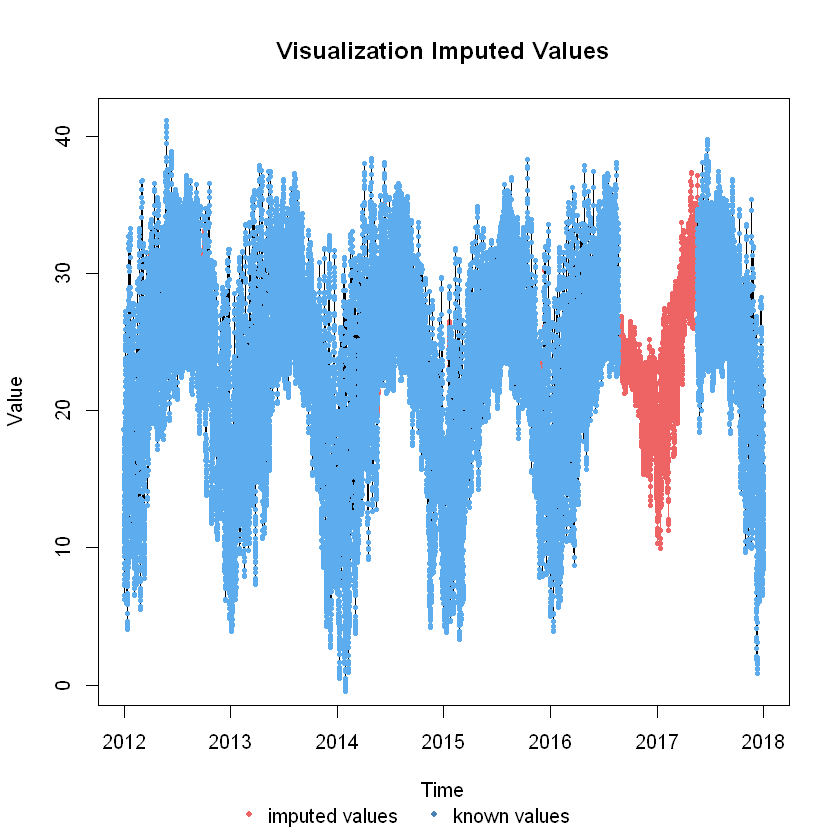

In [16]:
tesp1<-plotNA.imputations(tsNOROESTE[,'TOUT'],imputed[,"TOUT"])

In [76]:
test_missing<-which(is.na(tsNOROESTE[,'TOUT']))

In [53]:
#tsNOROESTE[test_missing[c(2:5,1)]]

### All the imputations for the northwest measurement station

In [201]:
library(ggplot2)
library(gridExtra)
library(grid)
library(lattice)

In [173]:
# Time series object to dataframe (For plotting purposes and easy handling)
imputeddf<-data.frame(as.matrix(imputed),date=time(imputed))

In [174]:
str(imputeddf)

'data.frame':	52608 obs. of  16 variables:
 $ CO   : num  2.08 5.2 2.51 3.33 1.26 0.91 1.68 1.06 0.66 0.66 ...
 $ NO   : num  16.6 154.4 47.4 96.7 10 ...
 $ NO2  : num  57.8 60.4 51.1 49 39.3 27.4 40 23.1 14.9 12.7 ...
 $ NOX  : num  74.4 214.8 98.5 145.7 49.3 ...
 $ O3   : num  5 8 4 6 7 8 3 12 22 25 ...
 $ PM10 : num  300 255 433 216 212 110 86 131 206 64 ...
 $ PM2.5: num  18.6 21.6 23.6 33.9 16.9 ...
 $ PRS  : num  716 716 716 716 717 ...
 $ RAINF: num  0 0 0 0 0 0 0 0 0 0 ...
 $ RH   : num  31 34 34 34 28 25 29 33 34 37 ...
 $ SO2  : num  14.5 16.5 10.9 9.9 7.5 6.4 6.7 6.5 6.5 6.4 ...
 $ SR   : num  0 0 0 0 0 0 0 0.006 0.062 0.06 ...
 $ TOUT : num  18.6 17.6 17.1 17 17.8 ...
 $ WDR  : num  330 295 332 310 317 318 281 37 111 220 ...
 $ WSR  : num  6.8 2.4 5.3 8.1 11 11.8 5.1 14.6 6 9.1 ...
 $ date : Time-Series  from 2012 to 2018: 2012 2012 2012 2012 2012 ...


In [175]:
imputeddf[test_missing[2],]

,CO,NO,NO2,NOX,O3,PM10,PM2.5,PRS,RAINF,RH,SO2,SR,TOUT,WDR,WSR,date
2198,1.091919,4.75064,17.98313,23.70091,78.7556,83.11657,22.30944,707.4821,0.002597257,42.07402,7.046253,0.9097455,30.50069,138.492,8.500733,2012.251


In [221]:
library(extrafont)
font_import()
fonts()

Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n]  y


Scanning ttf files in C:\WINDOWS\Fonts ...
Extracting .afm files from .ttf files...
C:\Windows\Fonts\AGENCYB.TTF => C:/Users/Gerson Colorado/.conda/envs/r_env/Lib/R/library/extrafontdb/metrics/AGENCYB
C:\Windows\Fonts\AGENCYR.TTF => C:/Users/Gerson Colorado/.conda/envs/r_env/Lib/R/library/extrafontdb/metrics/AGENCYR
C:\Windows\Fonts\ALGER.TTF => C:/Users/Gerson Colorado/.conda/envs/r_env/Lib/R/library/extrafontdb/metrics/ALGER
C:\Windows\Fonts\ANTQUAB.TTF => C:/Users/Gerson Colorado/.conda/envs/r_env/Lib/R/library/extrafontdb/metrics/ANTQUAB
C:\Windows\Fonts\ANTQUABI.TTF => C:/Users/Gerson Colorado/.conda/envs/r_env/Lib/R/library/extrafontdb/metrics/ANTQUABI
C:\Windows\Fonts\ANTQUAI.TTF => C:/Users/Gerson Colorado/.conda/envs/r_env/Lib/R/library/extrafontdb/metrics/ANTQUAI
C:\Windows\Fonts\arial.ttf => C:/Users/Gerson Colorado/.conda/envs/r_env/Lib/R/library/extrafontdb/metrics/arial
C:\Windows\Fonts\arialbd.ttf => C:/Users/Gerson Colorado/.conda/envs/r_env/Lib/R/library/extrafontdb/me

[1] "Agency FB"                       "Algerian"                       
  [3] "Arial Black"                     "Arial"                          
  [5] "Arial Narrow"                    "Arial Rounded MT Bold"          
  [7] "Bahnschrift"                     "Baskerville Old Face"           
  [9] "Bauhaus 93"                      "Bell MT"                        
 [11] "Berlin Sans FB"                  "Berlin Sans FB Demi"            
 [13] "Bernard MT Condensed"            "Blackadder ITC"                 
 [15] "Bodoni MT"                       "Bodoni MT Black"                
 [17] "Bodoni MT Condensed"             "Bodoni MT Poster Compressed"    
 [19] "Book Antiqua"                    "Bookman Old Style"              
 [21] "Bookshelf Symbol 7"              "Bradley Hand ITC"               
 [23] "Britannic Bold"                  "Broadway"                       
 [25] "Brush Script MT"                 "Calibri"                        
 [27] "Calibri Light"                   "Californian FB"                 
 [29] "Calisto MT"                      "Cambria"                        
 [31] "Candara"                         "Candara Light"                  
 [33] "Castellar"                       "Centaur"                        
 [35] "Century"                         "Century Gothic"                 
 [37] "Century Schoolbook"              "Chiller"                        
 [39] "Colonna MT"                      "Comic Sans MS"                  
 [41] "Consolas"                        "Constantia"                     
 [43] "Cooper Black"                    "Copperplate Gothic Bold"        
 [45] "Copperplate Gothic Light"        "Corbel"                         
 [47] "Corbel Light"                    "Courier New"                    
 [49] "Curlz MT"                        "Dubai"                          
 [51] "Dubai Light"                     "Dubai Medium"                   
 [53] "Ebrima"                          "Edwardian Script ITC"           
 [55] "Elephant"                        "Engravers MT"                   
 [57] "Eras Bold ITC"                   "Eras Demi ITC"                  
 [59] "Eras Light ITC"                  "Eras Medium ITC"                
 [61] "Felix Titling"                   "Footlight MT Light"             
 [63] "Forte"                           "Franklin Gothic Book"           
 [65] "Franklin Gothic Demi"            "Franklin Gothic Demi Cond"      
 [67] "Franklin Gothic Heavy"           "Franklin Gothic Medium"         
 [69] "Franklin Gothic Medium Cond"     "Freestyle Script"               
 [71] "French Script MT"                "Gabriola"                       
 [73] "Gadugi"                          "Garamond"                       
 [75] "Georgia"                         "Gigi"                           
 [77] "Gill Sans Ultra Bold"            "Gill Sans Ultra Bold Condensed" 
 [79] "Gill Sans MT"                    "Gill Sans MT Condensed"         
 [81] "Gill Sans MT Ext Condensed Bold" "Gloucester MT Extra Condensed"  
 [83] "Goudy Old Style"                 "Goudy Stout"                    
 [85] "Haettenschweiler"                "Harlow Solid Italic"            
 [87] "Harrington"                      "High Tower Text"                
 [89] "HoloLens MDL2 Assets"            "Impact"                         
 [91] "Imprint MT Shadow"               "Informal Roman"                 
 [93] "Ink Free"                        "Javanese Text"                  
 [95] "Jokerman"                        "Juice ITC"                      
 [97] "Kristen ITC"                     "Kunstler Script"                
 [99] "Wide Latin"                      "Leelawadee UI"                  
[101] "Leelawadee UI Semilight"         "Lucida Bright"                  
[103] "Lucida Calligraphy"              "Lucida Console"                 
[105] "Lucida Fax"                      "Lucida Handwriting"             
[107] "Lucida Sans"                     "Lucida Sans Typewriter"         
[109] 

In [234]:
fonts()

[1] "Agency FB"                       "Algerian"                       
  [3] "Arial Black"                     "Arial"                          
  [5] "Arial Narrow"                    "Arial Rounded MT Bold"          
  [7] "Bahnschrift"                     "Baskerville Old Face"           
  [9] "Bauhaus 93"                      "Bell MT"                        
 [11] "Berlin Sans FB"                  "Berlin Sans FB Demi"            
 [13] "Bernard MT Condensed"            "Blackadder ITC"                 
 [15] "Bodoni MT"                       "Bodoni MT Black"                
 [17] "Bodoni MT Condensed"             "Bodoni MT Poster Compressed"    
 [19] "Book Antiqua"                    "Bookman Old Style"              
 [21] "Bookshelf Symbol 7"              "Bradley Hand ITC"               
 [23] "Britannic Bold"                  "Broadway"                       
 [25] "Brush Script MT"                 "Calibri"                        
 [27] "Calibri Light"                   "Californian FB"                 
 [29] "Calisto MT"                      "Cambria"                        
 [31] "Candara"                         "Candara Light"                  
 [33] "Castellar"                       "Centaur"                        
 [35] "Century"                         "Century Gothic"                 
 [37] "Century Schoolbook"              "Chiller"                        
 [39] "Colonna MT"                      "Comic Sans MS"                  
 [41] "Consolas"                        "Constantia"                     
 [43] "Cooper Black"                    "Copperplate Gothic Bold"        
 [45] "Copperplate Gothic Light"        "Corbel"                         
 [47] "Corbel Light"                    "Courier New"                    
 [49] "Curlz MT"                        "Dubai"                          
 [51] "Dubai Light"                     "Dubai Medium"                   
 [53] "Ebrima"                          "Edwardian Script ITC"           
 [55] "Elephant"                        "Engravers MT"                   
 [57] "Eras Bold ITC"                   "Eras Demi ITC"                  
 [59] "Eras Light ITC"                  "Eras Medium ITC"                
 [61] "Felix Titling"                   "Footlight MT Light"             
 [63] "Forte"                           "Franklin Gothic Book"           
 [65] "Franklin Gothic Demi"            "Franklin Gothic Demi Cond"      
 [67] "Franklin Gothic Heavy"           "Franklin Gothic Medium"         
 [69] "Franklin Gothic Medium Cond"     "Freestyle Script"               
 [71] "French Script MT"                "Gabriola"                       
 [73] "Gadugi"                          "Garamond"                       
 [75] "Georgia"                         "Gigi"                           
 [77] "Gill Sans Ultra Bold"            "Gill Sans Ultra Bold Condensed" 
 [79] "Gill Sans MT"                    "Gill Sans MT Condensed"         
 [81] "Gill Sans MT Ext Condensed Bold" "Gloucester MT Extra Condensed"  
 [83] "Goudy Old Style"                 "Goudy Stout"                    
 [85] "Haettenschweiler"                "Harlow Solid Italic"            
 [87] "Harrington"                      "High Tower Text"                
 [89] "HoloLens MDL2 Assets"            "Impact"                         
 [91] "Imprint MT Shadow"               "Informal Roman"                 
 [93] "Ink Free"                        "Javanese Text"                  
 [95] "Jokerman"                        "Juice ITC"                      
 [97] "Kristen ITC"                     "Kunstler Script"                
 [99] "Wide Latin"                      "Leelawadee UI"                  
[101] "Leelawadee UI Semilight"         "Lucida Bright"                  
[103] "Lucida Calligraphy"              "Lucida Console"                 
[105] "Lucida Fax"                      "Lucida Handwriting"             
[107] "Lucida Sans"                     "Lucida Sans Typewriter"         
[109] 

In [177]:
for (var in colnames(imputeddf)[-16])
{
    test_missing<-which(is.na(tsNOROESTE[,var]))
    imputeddf[,paste(var,'_miss', sep="")]<-'Not missing'
    imputeddf[test_missing,paste(var,'_miss', sep="")]<-'Missing'
}

In [232]:
co_plot <-ggplot(imputeddf, aes(x=date, y=CO, color=CO_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none", axis.title.x=element_text(face='plain',size=7), axis.text.x=element_text(face='plain',size=7))
no_plot <-ggplot(imputeddf, aes(x=date, y=NO, color=NO_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
no2_plot <-ggplot(imputeddf, aes(x=date, y=NO2, color=NO2_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
nox_plot <-ggplot(imputeddf, aes(x=date, y=NOX, color=NOX_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
o3_plot <-ggplot(imputeddf, aes(x=date, y=O3, color=O3_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
pm10_plot <-ggplot(imputeddf, aes(x=date, y=PM10, color=PM10_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
pm25_plot <-ggplot(imputeddf, aes(x=date, y=PM2.5, color=PM2.5_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
psr_plot <-ggplot(imputeddf, aes(x=date, y=PRS, color=PRS_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
rainf_plot <-ggplot(imputeddf, aes(x=date, y=RAINF, color=RAINF_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
rh_plot <-ggplot(imputeddf, aes(x=date, y=RH, color=RH_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
so2_plot <-ggplot(imputeddf, aes(x=date, y=SO2, color=SO2_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() +theme(legend.position = "none")
sr_plot <-ggplot(imputeddf, aes(x=date, y=SR, color=SR_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
tout_plot <-ggplot(imputeddf, aes(x=date, y=TOUT, color=TOUT_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
wdr_plot <-ggplot(imputeddf, aes(x=date, y=WDR, color=WDR_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")
wsr_plot <-ggplot(imputeddf, aes(x=date, y=WSR, color=WSR_miss))  +geom_point(size=0.5, alpha=0.5) +theme_bw() + theme(legend.position = "none")

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Don't know how to automatically pick scale for object of type ts. Defaulting to 

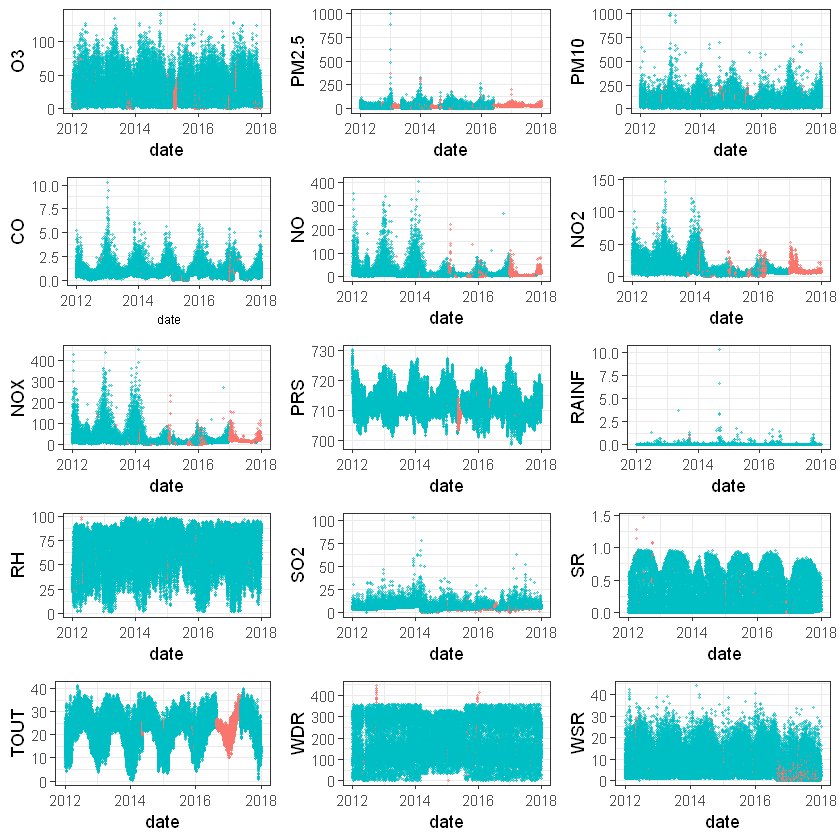

In [233]:
grid.arrange(o3_plot,pm25_plot,pm10_plot,co_plot,no_plot,no2_plot,nox_plot, psr_plot, rainf_plot, rh_plot, so2_plot, sr_plot, tout_plot, wdr_plot, wsr_plot, ncol=3)

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
"font family not found in Windows font database"

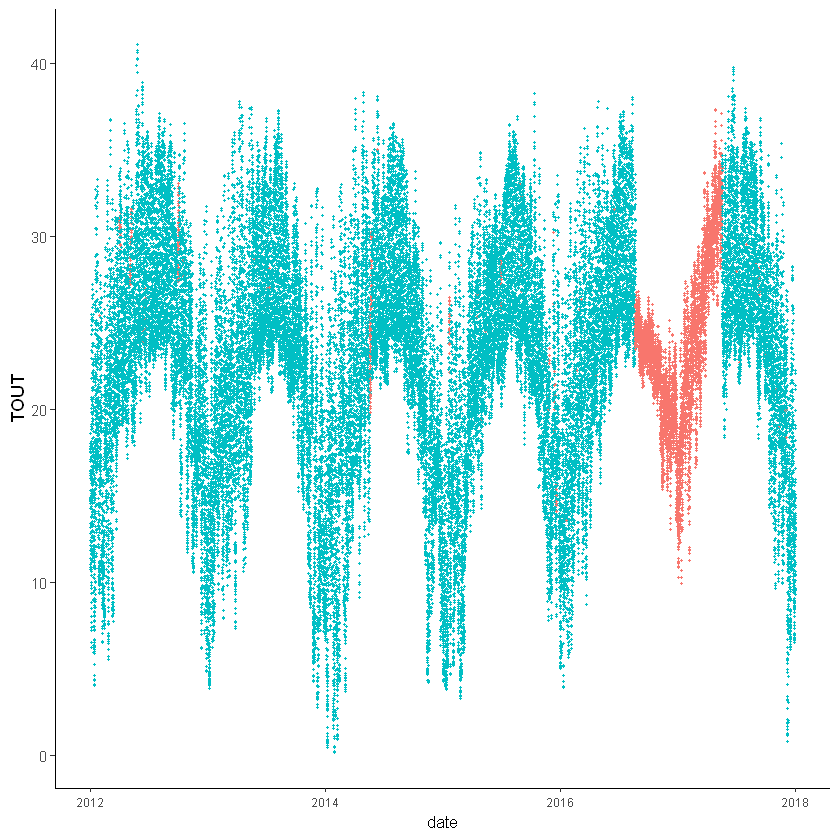

In [238]:
ts<-ggplot(imputeddf, aes(x=date, y=TOUT, color=TOUT_miss)) +geom_point(size=0.5) +theme_classic() +theme(axis.title.x=element_text(size=10, family='Franklin Gothic Medium Cond'),axis.text.x=element_text(size=7), legend.position = "none")
ts

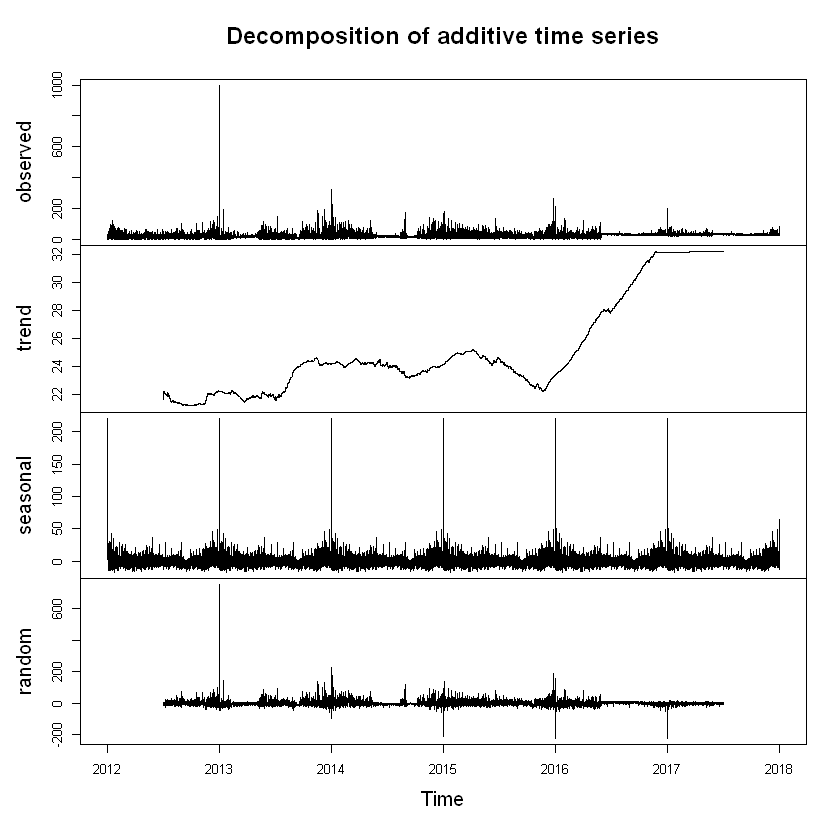

In [17]:
#Seasonalidad, diaria no capturada
imputeddecomposed <-decompose(imputed[,'PM2.5'])
plot(imputeddecomposed)